In [26]:
import rosbag
from geometry_msgs.msg import Vector3
import rospy
from crazyflie_msgs.msg import CrazyflieLog
import numpy as np
import matplotlib.pyplot as plt

bag = rosbag.Bag('/home/miguel/catkin_ws/src/crazyflie/crazyflie_controller/src/data/LQG_kalman_data2.bag')

time = []
position_kalman = []
vel_kalmam = []
position_optitrack = []
orientation_optitrack = []
vel_optitrack = []
vel_crazyflie = []
thrust_crazyflie = []
pitch_roll_crazyflie = []
z_crazyflie = []

for topic, msg, t in bag.read_messages(topics=['time', 'position_Optitrack', 'position_estimate_topic', 'vel_Optitrack', 'vel_estimate_topic', 'crazyflieLog', 'optitrack_pose']):
    if topic == 'time':
        time.append(msg.data)

    if topic == 'vel_Optitrack':
        vel_optitrack.append((msg.x, msg.y, msg.z))

    if topic == 'position_estimate_topic':
        position_kalman.append((msg.x, msg.y, msg.z))

    if topic == 'vel_estimate_topic':
        vel_kalmam.append((msg.x, msg.y, msg.z))

    if topic == 'optitrack_pose':
        position_optitrack.append((msg.pose.position.x, msg.pose.position.y, msg.pose.position.z))
        orientation_optitrack.append((msg.pose.orientation.x, msg.pose.orientation.y, msg.pose.orientation.z, msg.pose.orientation.w))

    if topic == 'crazyflieLog':
        vel_crazyflie.append((msg.vx, msg.vy, msg.vz))
        thrust_crazyflie.append(msg.thrust)
        pitch_roll_crazyflie.append((msg.roll, msg.pitch))
        z_crazyflie.append(msg.z)

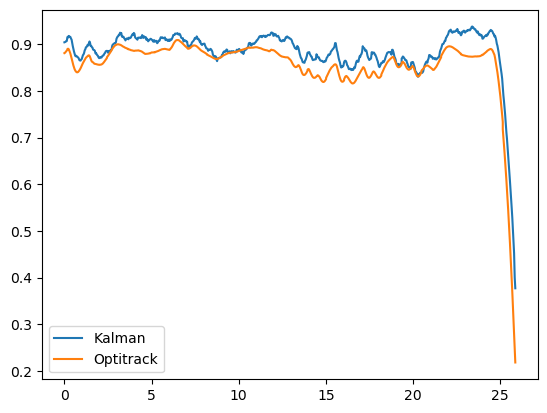

In [27]:
plt.plot(time, [x[2] for x in position_kalman], label='Kalman')
plt.plot(time, [x[2] for x in position_optitrack], label='Optitrack')
plt.legend()

In [28]:
# Find the indices where |vel_optitrack[2]| > 5
indices = [i for i, vel in enumerate(vel_optitrack) if abs(vel[1]) > 5]

# Set the velocities to 0
for i in indices:
    vel_optitrack[i] = (vel_optitrack[i][0], 0, vel_optitrack[i][2])

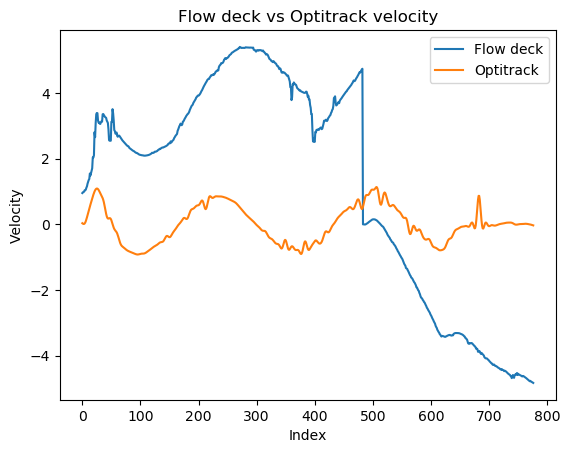

In [29]:
from scipy.signal import butter, filtfilt

# Assuming vel_state_estimate is your existing data array
data_to_filter = [x[1] for x in vel_optitrack]  # Extract the data to be filtered

# Sample rate and desired cutoff frequency (example values)
fs = 5000.0  # Sample rate in Hz
cutoff = 500.0  # Cutoff frequency in Hz

# Design a Butterworth lowpass filter (you can change filter type and parameters)
b, a = butter(N=6, Wn=cutoff / (0.5 * fs), btype='low')

# Apply the filter
filtered_data = filtfilt(b, a, data_to_filter)

# Plot the modified velocities
plt.plot(range(len(vel_crazyflie)), [x[1] for x in vel_crazyflie])
plt.plot(range(len(filtered_data)), filtered_data)
plt.xlabel('Index')
plt.ylabel('Velocity')
plt.title('Flow deck vs Optitrack velocity')
plt.legend(['Flow deck', 'Optitrack'])
plt.show()


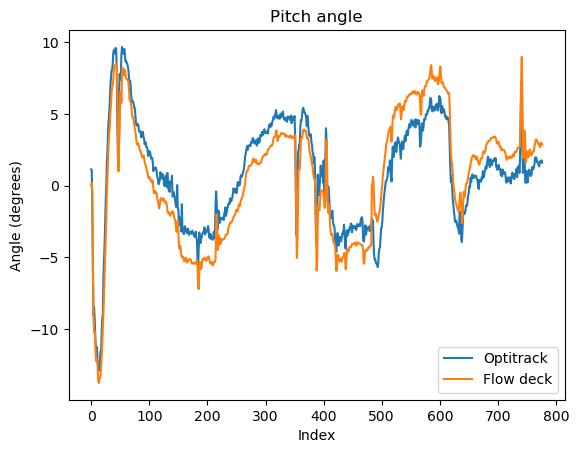

In [30]:
import tf.transformations as tf

# Convert quaternion to euler angles in degrees
orientation_degrees = [tf.euler_from_quaternion(orientation) for orientation in orientation_optitrack]
orientation_degrees = [[angle * 180 / np.pi for angle in angles] for angles in orientation_degrees]

plt.plot(range(len(orientation_degrees)), [x[0] for x in orientation_degrees])
plt.plot(range(len(pitch_roll_crazyflie)), [x[0] for x in pitch_roll_crazyflie])
plt.xlabel('Index')
plt.ylabel('Angle (degrees)')
plt.title('Pitch angle')
plt.legend(['Optitrack', 'Flow deck'])
plt.show()

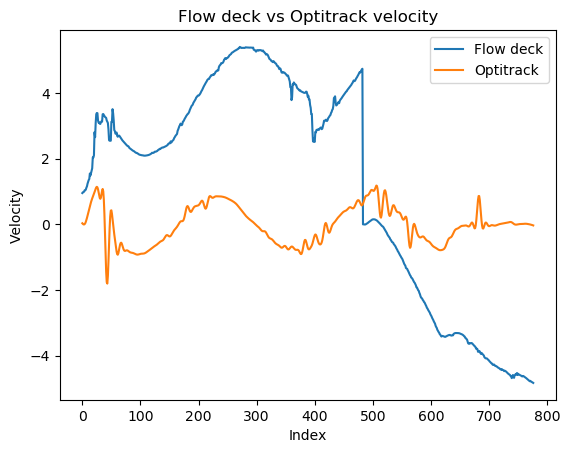

In [31]:
orientation = [tf.euler_from_quaternion(orientation) for orientation in orientation_optitrack]

rotated_velocities = []
for vel in vel_optitrack:
    yaw_angle = orientation[vel_optitrack.index(vel)][2]
    rotated_velocities.append((vel[0] * np.cos(yaw_angle) + vel[1] * np.sin(yaw_angle), -vel[0] * np.sin(yaw_angle) + vel[1] * np.cos(yaw_angle), vel[2]))

plt.plot(range(len(vel_crazyflie)), [x[1] for x in vel_crazyflie])

# Assuming rotated_velocities is your existing data array
data_to_filter = [x[1] for x in rotated_velocities]  # Extract the data to be filtered

# Sample rate and desired cutoff frequency (example values)
fs = 5000.0  # Sample rate in Hz
cutoff = 500.0  # Cutoff frequency in Hz

# Design a Butterworth lowpass filter (you can change filter type and parameters)
b, a = butter(N=6, Wn=cutoff / (0.5 * fs), btype='low')

# Apply the filter
filtered_data = filtfilt(b, a, data_to_filter)

plt.plot(range(len(filtered_data)), filtered_data)

plt.xlabel('Index')
plt.ylabel('Velocity')
plt.title('Flow deck vs Optitrack velocity')
plt.legend(['Flow deck', 'Optitrack'])
plt.show()

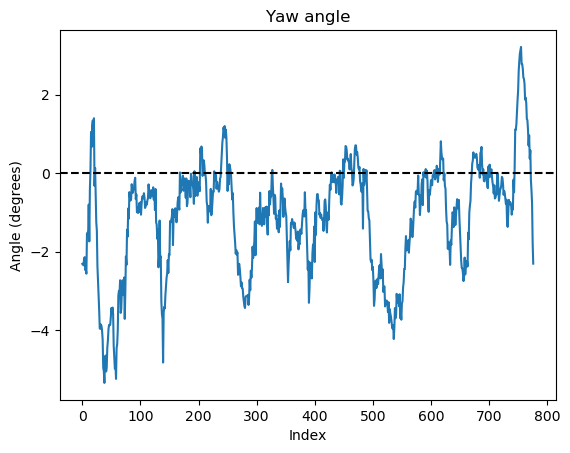

In [32]:
plt.plot(range(len(orientation_degrees)), [x[2] for x in orientation_degrees])
plt.axhline(y=0.0, color='k', linestyle='--')
plt.title('Yaw angle')
plt.xlabel('Index')
plt.ylabel('Angle (degrees)')
plt.show()

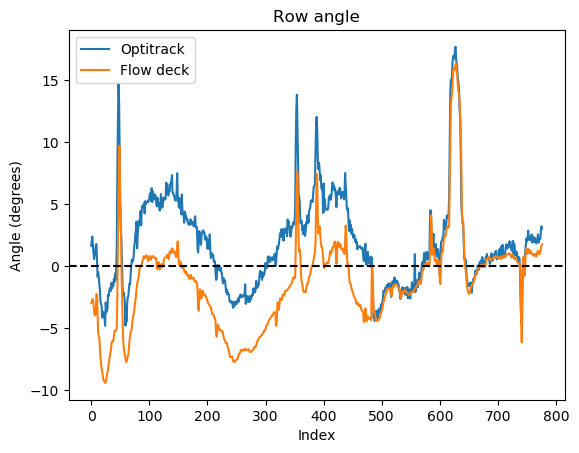

In [33]:
# Convert quaternion to euler angles in degrees
orientation_degrees = [tf.euler_from_quaternion(orientation) for orientation in orientation_optitrack]
orientation_degrees = [[angle * 180 / np.pi for angle in angles] for angles in orientation_degrees]

plt.plot(range(len(orientation_degrees)), [x[1] for x in orientation_degrees])
plt.plot(range(len(pitch_roll_crazyflie)), [-x[1] for x in pitch_roll_crazyflie])
plt.xlabel('Index')
plt.ylabel('Angle (degrees)')
plt.title('Row angle')
plt.legend(['Optitrack', 'Flow deck'])
plt.axhline(y=0.0, color='k', linestyle='--')

plt.show()

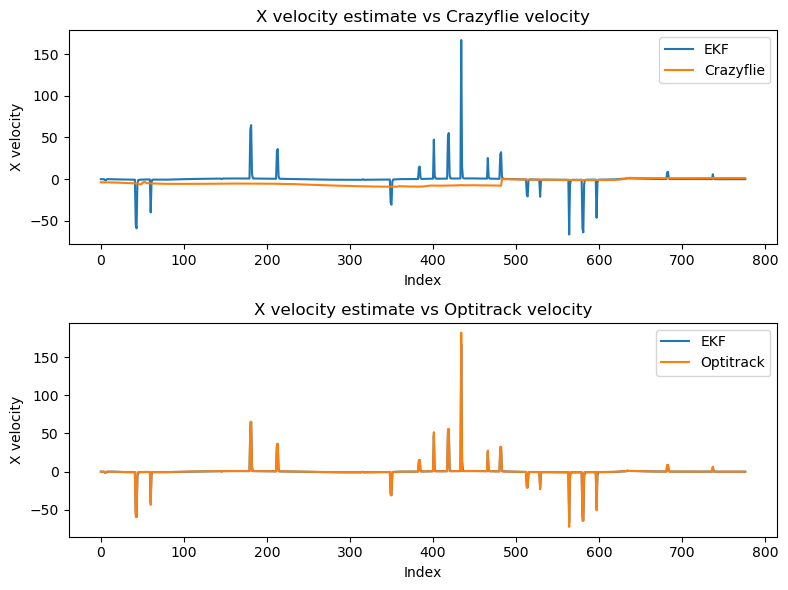

In [34]:
import numpy as np
import sympy as sp

class ExtendedKalmanFilter:
    def __init__(self, initial_state, initial_error_covariance, dt, m, Kvx, Kvy, Kvz, Rw, Rv):
        # Symbolic variables for state and control input
        self.x, self.y, self.z, self.x_dot_body, self.y_dot_body, self.z_dot_body = sp.symbols('x y z x_dot_body y_dot_body z_dot_body')
        self.theta, self.phi, self.psi, self.t = sp.symbols('theta phi psi t')

        # State and control input as NumPy arrays
        self.state_estimate = np.array(initial_state)
        self.error_covariance = np.array(initial_error_covariance)

        # Constants and time step
        self.dt = dt
        self.m = m
        self.g = 9.81
        self.Kvx = Kvx
        self.Kvy = Kvy
        self.Kvz = Kvz

        # Process and measurement noise covariance matrices
        self.Rw = np.array(Rw)
        self.Rv = np.array(Rv)

        # Precompute the symbolic state transition function and its Jacobian
        self._precompute_dynamics()

    def _precompute_dynamics(self):
        # Define the symbolic state transition equations
        state = sp.Matrix([self.x, self.y, self.z, self.x_dot_body, self.y_dot_body, self.z_dot_body])
        control_input = sp.Matrix([self.theta, self.phi, self.psi, self.t])

        # World frame dynamics
        x_world = sp.cos(self.psi) * self.x_dot_body + sp.sin(self.psi) * self.y_dot_body
        y_world = -sp.sin(self.psi) * self.x_dot_body + sp.cos(self.psi) * self.y_dot_body
        z_world = self.z_dot_body
        x_ddot_w = -self.Kvx / self.m * self.x_dot_body + self.t / self.m * sp.sin(self.theta)
        y_ddot_w = -self.Kvy / self.m * self.y_dot_body + self.t / self.m * sp.sin(self.phi)
        z_ddot_w = -self.Kvz / self.m * self.z_dot_body + self.t / self.m * sp.cos(self.theta) * sp.cos(self.phi) - self.g

        # State transition equations
        new_state = sp.Matrix([
            self.x + x_world * self.dt,
            self.y + y_world * self.dt,
            self.z + z_world * self.dt,
            self.x_dot_body + x_ddot_w * self.dt,
            self.y_dot_body + y_ddot_w * self.dt,
            self.z_dot_body + z_ddot_w * self.dt
        ])

        # Compute the Jacobian matrix of the state transition function
        self.jacobian_func = sp.lambdify((state, control_input), new_state.jacobian(state), 'numpy')

    def update(self, measurement, control_input):
        # Prediction
        control_input_np = np.array(control_input, dtype=float)
        jacobian_matrix = self.jacobian_func(self.state_estimate, control_input_np)

        # State transition (numerical computation)
        self.state_estimate = self._state_transition(self.state_estimate, control_input_np)
        self.error_covariance = jacobian_matrix @ self.error_covariance @ jacobian_matrix.T + self.Rw

        # Update
        H = np.eye(6)  # Measurement matrix
        innovation = measurement - H @ self.state_estimate
        innovation_covariance = H @ self.error_covariance @ H.T + self.Rv
        kalman_gain = self.error_covariance @ H.T @ np.linalg.pinv(innovation_covariance)
        self.state_estimate = self.state_estimate + kalman_gain @ innovation
        self.error_covariance = (np.eye(6) - kalman_gain @ H) @ self.error_covariance

        return self.state_estimate, kalman_gain

    def _state_transition(self, state, control_input):
        # Unpack the state and control input
        x, y, z, x_dot_body, y_dot_body, z_dot_body = state
        theta, phi, psi, t = control_input

        # Calculate the world frame dynamics
        x_world = np.cos(psi) * x_dot_body + np.sin(psi) * y_dot_body
        y_world = -np.sin(psi) * x_dot_body + np.cos(psi) * y_dot_body
        z_world = z_dot_body
        x_ddot_w = -self.Kvx / self.m * x_dot_body + t / self.m * np.sin(theta)
        y_ddot_w = -self.Kvy / self.m * y_dot_body + t / self.m * np.sin(phi)
        z_ddot_w = -self.Kvz / self.m * z_dot_body + t / self.m * np.cos(theta) * np.cos(phi) - self.g

        # State transition
        new_state = np.array([
            x + x_world * self.dt,
            y + y_world * self.dt,
            z + z_world * self.dt,
            x_dot_body + x_ddot_w * self.dt,
            y_dot_body + y_ddot_w * self.dt,
            z_dot_body + z_ddot_w * self.dt
        ])

        return new_state


# Define the initial state and error covariance
initial_state = [0, 0, 0, 0, 0, 0]
initial_error_covariance = np.eye(6) * 0.1

# Define the process and measurement noise covariance matrices
Rw = np.diag([0.01, 0.01, 0.01, 0.1, 0.1, 0.1])  # Process noise covariance
Rv = np.diag([0.5, 0.5, 5.0, 0.01, 0.01, 0.01])  # Measurement noise covariance

# Create the EKF
ekf = ExtendedKalmanFilter(initial_state, initial_error_covariance, 0.01, 0.0333, 0.03, 0.03, 0.0, Rw, Rv)

# Define the control input and measurement
pitch_roll_crazyflie_rad = np.array(pitch_roll_crazyflie) * np.pi / 180
a_max = 14.3
conversao_digital = 60000/a_max

# Define the control input and measurement
m = 0.0333
g = 9.81
thrust = (np.array(thrust_crazyflie)*m - g) / conversao_digital

state_estimate_ = []
position_with_noise = []
for i in range(len(vel_crazyflie)):

    yaw_rad = orientation_degrees[i][2] * np.pi / 180
    control_input = [pitch_roll_crazyflie_rad[i][0], pitch_roll_crazyflie_rad[i][1], yaw_rad, thrust[i]]

    # # Update the EKF
    # state_estimate, kalman_gain = ekf.update(measurement, control_input)
    # state_estimate_.append(state_estimate)
    # measurement = [position_optitrack[i][0], position_optitrack[i][1], position_optitrack[i][2], vel_optitrack[i][0], vel_optitrack[i][1], vel_optitrack[i][2]]

    # Update the EKF
    measurement = [
        position_optitrack[i][0] + np.random.normal(0, 0.50),
        position_optitrack[i][1] + np.random.normal(0, 0.50),
        position_optitrack[i][2] + np.random.normal(0, 0.50),
        vel_optitrack[i][0],
        vel_optitrack[i][1],
        vel_optitrack[i][2]
    ]

    position_with_noise.append(measurement[:3])

    # Update the EKF
    state_estimate, kalman_gain = ekf.update(measurement, control_input)
    state_estimate_.append(state_estimate)

# Plot the estimated state
state_estimate_ = np.array(state_estimate_)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot X velocity estimate
ax1.plot(range(len(state_estimate_)), state_estimate_[:, 3])
ax1.plot(range(len(vel_crazyflie)), [x[0] for x in vel_crazyflie])
ax1.set_xlabel('Index')
ax1.set_ylabel('X velocity')
ax1.set_title('X velocity estimate vs Crazyflie velocity')
ax1.legend(['EKF', 'Crazyflie'])

# Plot Y velocity estimate
ax2.plot(range(len(state_estimate_)), state_estimate_[:, 3])
ax2.plot(range(len(vel_optitrack)), [x[0] for x in vel_optitrack])
ax2.set_xlabel('Index')
ax2.set_ylabel('X velocity')
ax2.set_title('X velocity estimate vs Optitrack velocity')
ax2.legend(['EKF', 'Optitrack'])

plt.tight_layout()
plt.show()

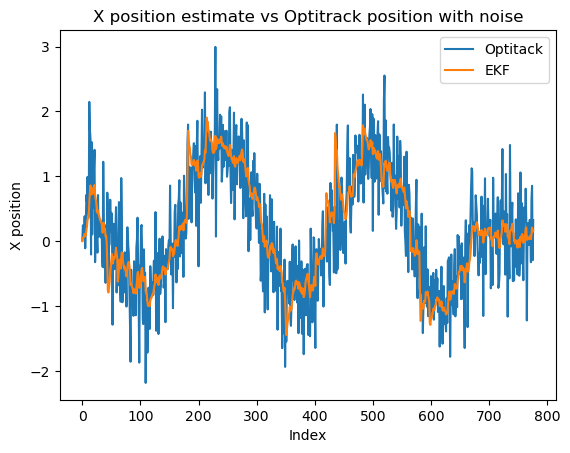

In [35]:
state_estimate_ = np.array(state_estimate_)
plt.plot(range(len(position_with_noise)), [x[0] for x in position_with_noise])
plt.plot(range(len(state_estimate_)), state_estimate_[:, 0])

# plt.plot(range(len(position_optitrack)), [x[0] for x in position_optitrack])
plt.xlabel('Index')
plt.ylabel('X position')
plt.title('X position estimate vs Optitrack position with noise')
plt.legend(['Optitack', 'EKF'])
plt.show()


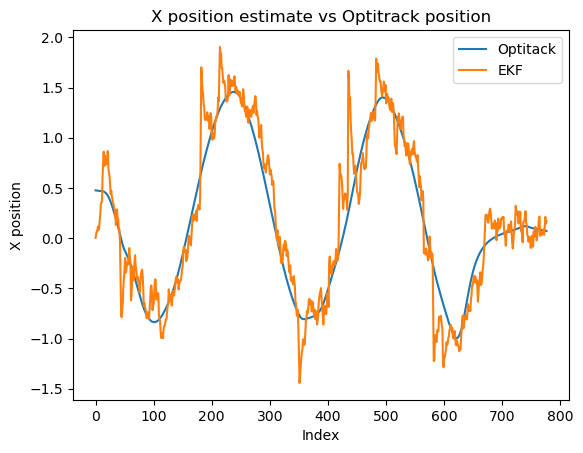

In [36]:
state_estimate_ = np.array(state_estimate_)
plt.plot(range(len(position_optitrack)), [x[0] for x in position_optitrack])
plt.plot(range(len(state_estimate_)), state_estimate_[:, 0])

# plt.plot(range(len(position_optitrack)), [x[0] for x in position_optitrack])
plt.xlabel('Index')
plt.ylabel('X position')
plt.title('X position estimate vs Optitrack position')
plt.legend(['Optitack', 'EKF'])
plt.show()

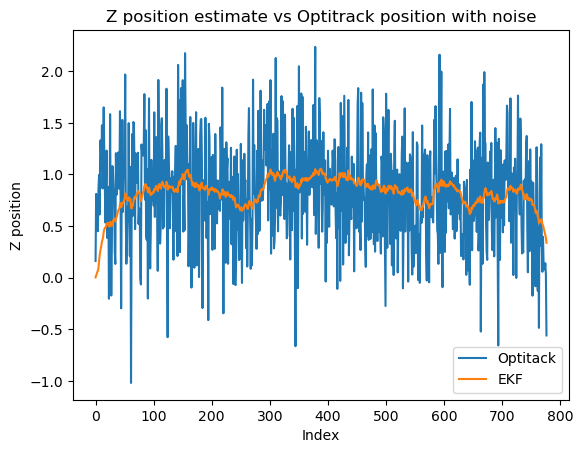

In [37]:
state_estimate_ = np.array(state_estimate_)
plt.plot(range(len(position_with_noise)), [x[2] for x in position_with_noise])
plt.plot(range(len(state_estimate_)), state_estimate_[:, 2])

# plt.plot(range(len(position_optitrack)), [x[0] for x in position_optitrack])
plt.xlabel('Index')
plt.ylabel('Z position')
plt.title('Z position estimate vs Optitrack position with noise')
plt.legend(['Optitack', 'EKF'])
plt.show()


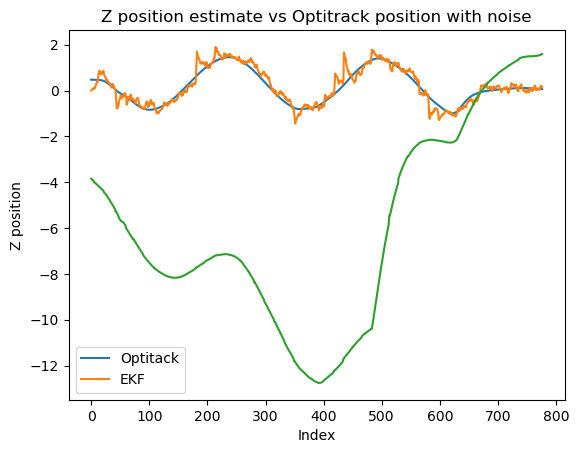

In [39]:
state_estimate_ = np.array(state_estimate_)
plt.plot(range(len(position_optitrack)), [x[0] for x in position_optitrack])
plt.plot(range(len(state_estimate_)), state_estimate_[:, 0])
plt.plot(range(len(position_kalman)), [x[0] for x in position_kalman])

# plt.plot(range(len(position_optitrack)), [x[0] for x in position_optitrack])
plt.xlabel('Index')
plt.ylabel('Z position')
plt.title('Z position estimate vs Optitrack position with noise')
plt.legend(['Optitack', 'EKF'])
plt.show()
